# Multimodal Early‑Classification of ZTF Transients  
### *A mini “AppleCiDEr” hackathon*


### Get the data here! https://drive.google.com/drive/u/0/folders/19EUnPU4AyN8Y0dF_CYsNHHxz94qjL1q9 

You should download all the data_train_multi files.



Welcome to the **grand‑finale hackathon** of the 2025 ZTF Summer School!  
In the next few hours you will build, train, and evaluate a **multimodal classifier** that decides—within the **first 10 days** of discovery—what kind of optical transient we are watching.

Why does *early* classification matter?

* *Rapid follow‑up:* scarce resources (Spectrographs, JWST, HST, VLA…) must be allocated **before** a transient fades.  
* *Fast transients physics:* the more data we have, the better we can constrain models.  
* *Event brokers:* surveys such as ZTF, Rubin, ... stream millions of alerts/night; automated early triage is critical!

We will focus our taxonomy into **five broad classes** to keep training fast for the time scale of the hackathon:

| Broad class | Typical zoo members |
|-------------|--------------------|
| **SNI**  | SN Ia, Ib, Ic |
| **SNII** | SN II, II‑P, IIn, II‑b |
| **CV** | Cataclysmic Variables |
| **AGN** | Active Galactic Nuclei |
| **TDE** |  Tidal Disruption Events |

In spirit we are reproducing a toy version of  
> **“Applying Multimodal Learning to Classify Transient Detections Early (AppleCiDEr) I: Dataset, Methods, and Infrastructure”** – *AJ Brown et al., 2025*.

Good luck and have fun!

As a starting point, we are providing an early development version of AppleCider. The cells are supposed to be more of a guide then a fully functional code; There will be places where you will either have to complete available code or write your own. Feel free to transfer the parts relevant to you to your own coding environment.

This version of the **multimodal classifier** combines:

| Modality | Encoder | Key Idea |
|----------|---------|----------|
| **Photometry** | Transformer | temporal self‑attention on light‑curves |
| **Spectra** | CNN | harvesting power from 2D CNNs |
| **Image + Metadata** | astroMiNN | Mixture‑of‑Experts fusion tower |
| **Fusion** | Gated late‑fusion | sample‑adaptive weighting of branch logits |
  
Everything is thoroughly annotated, but if you have any questions about any of the bits, please let us know :) 

> **Your challenge:** improve BALANCED ACCURACY of the multi-modal classifier. Feel free to exercise all of your creativity and substitute any of the blocks in this code, to implement any technique you like. We left some tips that might be worth exploring on the “💡 Try This” cells sprinkled throughout.
>
> Happy Hacking!


## 0 · Setup & Dependencies

- We suggest making a fresh conda environment for this challenge.  
- If you run locally, uncomment the cell below to install some of the important Python packages.

Feel free to add any extra libraries you need (like `tqdm`, `rich`, `torchmetrics`).

In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install numpy pandas scikit-learn seaborn wandb tqdm rich

In [3]:
import os, math, argparse, warnings, json, random
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score,
                             precision_score, recall_score, average_precision_score,
                             confusion_matrix, roc_curve, auc, precision_recall_curve,
                             top_k_accuracy_score)
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

# Pretty plots
sns.set(style='ticks', font_scale=1.2)
plt.rcParams['figure.autolayout'] = True
wandb.require("service")
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.


## 1. Configuration

Edit the **data paths** below if you stashed the CSVs or `.npy` files in a different directory.  
All other hyper‑parameters are sane defaults, but you are encouraged to play:

* Transformer depth, heads, dropout  
* CNN kernel sizes / channels  
* Number of experts in astroMiNN  
* Learning rate schedule, batch size, $\gamma$ for focal‑loss

> **💡 Try This:** crank `d_model` to 256 and halve `epochs` while using cosine restarts; Sometimes, bigger models converge faster, but can be less stable.



In [7]:
class CFG:
    # ── data paths (EDIT ME) ────────────────────────────────────────────────
    csv_path      = "data_train_multi_10.csv"
    root_path     = "./data_train_multi/day10"
    test_csv_path = "data_test_multi_10.csv"
    test_root     = "./data_test_multi/day10"

    # ── experiment tracking ────────────────────────────────────────────────
    project       = "multimodal_late_fusion_gated"
    wandb_mode    = "disabled"         # 'disabled' for offline

    # ── optimisation ───────────────────────────────────────────────────────
    batch_size    = 128
    epochs        = 150
    lr            = 1e-6
    weight_decay  = 1e-2
    patience      = 50
    num_workers   = 10
    gamma         = 2.0              # focal‑loss γ
    seed          = 42

    # ── photometry Transformer ─────────────────────────────────────────────
    d_model       = 128
    num_layers    = 8
    num_heads     = 4
    dropout       = 0.3
    max_len       = 500

    # ── spectra CNN ────────────────────────────────────────────────────────
    grid_size           = 59
    conv1_filters       = 32
    conv1_kernel        = 7
    conv2_filters       = 64
    conv2_kernel        = 7
    pool_size           = 2
    fc_units_spec       = 2048
    fc_dropout          = 0.3

    # ── astroMiNN (image + metadata) ───────────────────────────────────────
    astro_input_dim           = 9
    astro_hidden_dim          = 128
    astro_proj_dim            = 256
    astro_num_experts         = 10
    astro_num_fusion_experts  = 5

cfg = CFG()

# Determinism helpers
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)
random.seed(cfg.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cpu


In [8]:
# ── taxonomy ---------------------------------------------------------------
BROAD_CLASSES = ["SNI", "SNII", "Cataclysmic", "AGN", "TDE"]
NUM_CLASSES   = len(BROAD_CLASSES)
ORIG2BROAD = {
    "SN Ia":"SNI","SN Ib":"SNI","SN Ic":"SNI",
    "SN II":"SNII","SN IIP":"SNII","SN IIn":"SNII","SN IIb":"SNII",
    "Cataclysmic":"Cataclysmic","AGN":"AGN","Tidal Disruption Event":"TDE"
}
BROAD2ID = {c:i for i,c in enumerate(BROAD_CLASSES)}

# ── pre‑computed metadata normalisation stats ------------------------------
METADATA_STATS = {
    'sgscore1': {'mean': 0.236, 'std': 0.266},
    'sgscore2': {'mean': 0.401, 'std': 0.328},
    'distpsnr1': {'mean': 3.151, 'std': 3.757},
    'distpsnr2': {'mean': 9.269, 'std': 6.323},
    'nmtchps': {'mean': 9.231, 'std': 8.089},
    'sharpnr': {'mean': 0.253, 'std': 0.256},
    'scorr': {'mean': 22.089, 'std': 16.757},
    'ra': {'mean': 0, 'std': 1},
    'dec': {'mean': 0, 'std': 1}
}

## 2 · Data Exploration


Before touching any code, let’s *look* at the dataset. Your first exercise is to obtain as much information from the dataset as you can by plotting data for individual objects, statistics of relevant features...

* **Rows:** individual ZTF objects (one per transient)  
* **file:** `.npy` bundle containing the four modalities  
* **type:** label map 

As a first suggestion, let’s peek at the CSV that indexes our multimodal samples and visualise the class distribution.


,name,file,type
0,ZTF17aaaemzh,ZTF17aaaemzh_alert_0.npy,Cataclysmic
1,ZTF17aaaikab,ZTF17aaaikab_alert_9.npy,Cataclysmic
2,ZTF17aaajazz,ZTF17aaajazz_alert_1.npy,AGN
3,ZTF17aaajlbs,ZTF17aaajlbs_alert_10.npy,Cataclysmic
4,ZTF17aaajlfw,ZTF17aaajlfw_alert_13.npy,Cataclysmic


Total samples: 8,679


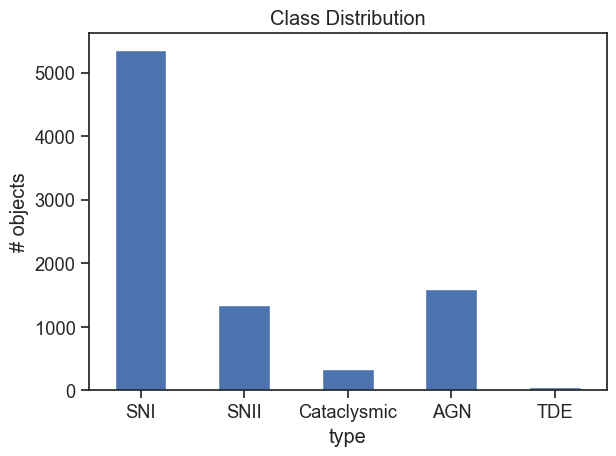

In [9]:
full_df = pd.read_csv(cfg.csv_path)
full_df['type'] = full_df['type'].map(ORIG2BROAD)
display(full_df.head())

print(f"Total samples: {len(full_df):,}")
class_counts = full_df['type'].value_counts().reindex(BROAD_CLASSES).fillna(0)
class_counts.plot(kind='bar', rot=0)
plt.title('Class Distribution'); plt.ylabel('# objects'); plt.show()

> **💡 Try This:** Ask yourself whether this level of class imbalance will significantly affect your training. If yes, what techniques could you employ to fight it? Oversampling the minority classes or Undersampling the majority classes are two common techniques, but there are many others out there!


## 3 · Dataset & Dataloaders

### Anatomy of one sample

| Tensor | Shape | Meaning |
|--------|-------|---------|
| `phot` | `(T, 4)` | ZTF light‑curve (g/r flux, flux‑err, mjd) |
| `spec_img` | `(1, 59, 59)` | Raw spectrum ▸ z‑score ▸ square grid |
| `meta_vec` | `(9,)` | Contextual features (sgscore, distpsnr, …) |
| `image` | `(3, H, W)` | Triplet of Image Cutouts, scaled to [0, 1] |
| `label` | scalar | 0–4 for the 5 broad classes |

Key implementation tricks:

1. Padding + masking for variable‑length photometry sequences so the Transformer ignores padded tokens.  
2. StandardScaler on spectra voxels—fitted on *training* set only (very important, to avoid leakage!).  
3. On‑the‑fly square‑grid mapping so you can easily swap‑in different `grid_size` or even 1‑D CNNs.

> **💡 Try This:** If preprocessing the spectra is taking too much performance out of your dataloader, cache the mapped spectra on disk for a decent speed‑up at the cost of some RAM.




In [10]:
class MultiModalDataset(Dataset):
    """Custom dataset returning five tensors per sample."""
    def __init__(self, df: pd.DataFrame, root: Path,
                 phot_mean=None, phot_std=None, spec_scaler=None,
                 grid_size=cfg.grid_size, transform=None):
        self.df   = df.reset_index(drop=True)
        self.root = Path(root)
        self.phot_mean = phot_mean
        self.phot_std  = phot_std
        self.spec_scaler = spec_scaler
        self.grid_size   = grid_size
        self.transform   = transform

    def __len__(self): return len(self.df)

    # -------------------------------------------------------
    def _load_sample(self, row):
        sample = np.load(self.root / row['file'], allow_pickle=True).item()
        phot   = torch.tensor(sample['photometry'], dtype=torch.float32)
        spec   = np.nan_to_num(sample['spectra'][0])

        # --- metadata vector (z‑score or min‑max) ----------
        m = sample['metadata']
        meta_vec = torch.tensor([
            (m['sgscore1']  - METADATA_STATS['sgscore1']['mean']) / METADATA_STATS['sgscore1']['std'],
            (m['sgscore2']  - METADATA_STATS['sgscore2']['mean']) / METADATA_STATS['sgscore2']['std'],
            (m['distpsnr1'] - METADATA_STATS['distpsnr1']['mean']) / METADATA_STATS['distpsnr1']['std'],
            (m['distpsnr2'] - METADATA_STATS['distpsnr2']['mean']) / METADATA_STATS['distpsnr2']['std'],
            (m['nmtchps']   - METADATA_STATS['nmtchps']['mean'])  / METADATA_STATS['nmtchps']['std'],
            (m['sharpnr']   - METADATA_STATS['sharpnr']['mean'])  / METADATA_STATS['sharpnr']['std'],
            (m['scorr']     - METADATA_STATS['scorr']['mean'])    / METADATA_STATS['scorr']['std'],
            (m['ra'] / 360.0),
            ((m['dec'] + 90.0) / 180.0)
        ], dtype=torch.float32)

        # --- PSF stamp -------------------------------------
        img = torch.tensor(sample['images'], dtype=torch.float32).permute(2,0,1) / 255.0
        if self.transform: img = self.transform(img)
        return phot, spec, meta_vec, img

    # -------------------------------------------------------
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        phot, spec, meta_vec, img = self._load_sample(row)

        # spectra → square grid
        spec_std = self.spec_scaler.transform([spec])[0]
        needed   = self.grid_size ** 2
        if spec_std.shape[0] < needed:
            spec_std = np.pad(spec_std, (0, needed - spec_std.shape[0]))
        elif spec_std.shape[0] > needed:
            spec_std = spec_std[:needed]
        spec_img = torch.tensor(spec_std.reshape(self.grid_size, self.grid_size),
                                dtype=torch.float32).unsqueeze(0)

        label = BROAD2ID[row['type']]
        return phot, spec_img, meta_vec, img, label


In [11]:
def compute_phot_mean_std(ds):
    """Per‑channel mean/std over an *un‑padded* photometry dataset."""
    sums, sqs, n = torch.zeros(4), torch.zeros(4), 0
    for phot, *_ in ds:
        sums += phot.sum(0)
        sqs  += (phot ** 2).sum(0)
        n    += phot.shape[0]
    mean = (sums / n)[None, None, :]
    std  = torch.sqrt(sqs / n - mean.squeeze() ** 2)[None, None, :]
    return mean, std

def build_collate(mean, std):
    def collate(batch):
        phot_seqs, spec_imgs, meta_vecs, img_tensors, labels = zip(*batch)

        spec_batch = torch.stack(spec_imgs)
        meta_batch = torch.stack(meta_vecs)
        img_batch  = torch.stack(img_tensors)

        lengths = [p.shape[0] for p in phot_seqs]
        padded  = pad_sequence(phot_seqs, batch_first=True)
        mask    = torch.stack([
            torch.cat([torch.zeros(l), torch.ones(padded.shape[1]-l)])
            for l in lengths
        ]).bool()
        normed  = (padded - mean) / (std + 1e-8)
        return normed, mask, spec_batch, meta_batch, img_batch, torch.tensor(labels)
    return collate

## 4 · Modal Encoders

### Photometry Transformer  
Temporal self‑attention excels at capturing irregular cadence and long‑range dependencies.  
We prepend a learnable **[CLS] token** whose output embedding summarises the entire light‑curve.

> **💡 Try This:** Can just the [CLS] token hold all the information about the transient classes or would be better to use all output encondings from the Transformer model? 


> **💡 Try This:** Can we include a better Positional Encoding, that doesn't rely on the index of the photometric point, but actually encodes the timing between observations? Learnable, time-aware positional encoding was shown to do better in time-series. 

*Input*: padded sequence `x = (time, g_flux, r_flux, i_flux) ∈ ℝ^{B×T×4}`.   
*PosEnc*: $ \text{PE}(t,2i)=\sin(t/10000^{2i/d}) $, $ \text{PE}(t,2i+1)=\cos(t/10000^{2i/d}) $

### Spectra CNN  
We reshape each 1‑D spectrum into a 2‑D postage‑stamp and apply two convolutional blocks. Cool reference about Spectrum Classification: *DASH* (Muthukrishna et al. 2019).  
Feel free to:

* switch to a **1‑D residual CNN**  
* treat the spectrum as a **sentence** and use a Transformer  
* replace pooling with **strided convolutions**

### astroMiNN (Image + Metadata)  
A light‑weight Mixture‑of‑Experts inspired by *Mixture‑of‑Experts for Multimodal Supernova Classification* (Caupin et al., 2024).  
Separate “towers” encode PSF‑shape, localisation, and contextual features, then a **fusion‑router** softly combines them.

> **💡 Try This:** swap the Images tower for a pretrained ViT “patchified” stamp!



In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-math.log(1e4) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):  # (B, T, D)
        return x + self.pe[:, :x.size(1)]

class PhotometryEncoder(nn.Module):
    """A CLS‑token Transformer encoder for irregular light‑curves."""
    def __init__(self, input_dim=4):
        super().__init__()
        self.embed = nn.Linear(input_dim, cfg.d_model)
        self.cls   = nn.Parameter(torch.zeros(1, 1, cfg.d_model))
        self.pos   = PositionalEncoding(cfg.d_model, cfg.max_len + 1)
        enc_layer  = nn.TransformerEncoderLayer(cfg.d_model, cfg.num_heads,
                                                cfg.d_model * 4, cfg.dropout, batch_first=True)
        self.enc   = nn.TransformerEncoder(enc_layer, cfg.num_layers)
        self.norm  = nn.LayerNorm(cfg.d_model)

    def forward(self, x, pad_mask):
        B = x.size(0)
        tok = self.cls.expand(B, -1, -1)
        x   = torch.cat([tok, self.embed(x)], 1)
        pad = torch.cat([torch.zeros(B, 1, dtype=torch.bool, device=x.device), pad_mask], 1)
        h   = self.enc(self.pos(x), src_key_padding_mask=pad)
        return self.norm(h[:, 0])


In [13]:
class SpectraEncoder(nn.Module):
    """DASH‑style 2‑layer CNN over a (1, 59, 59) spectra image."""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, cfg.conv1_filters, cfg.conv1_kernel,
                               padding=cfg.conv1_kernel // 2)
        self.bn1   = nn.BatchNorm2d(cfg.conv1_filters)
        self.pool1 = nn.MaxPool2d(cfg.pool_size)
        self.conv2 = nn.Conv2d(cfg.conv1_filters, cfg.conv2_filters, cfg.conv2_kernel,
                               padding=cfg.conv2_kernel // 2)
        self.bn2   = nn.BatchNorm2d(cfg.conv2_filters)
        self.pool2 = nn.MaxPool2d(cfg.pool_size)
        out_size   = cfg.grid_size // (cfg.pool_size * cfg.pool_size)
        self.flat  = nn.Flatten()
        self.fc1   = nn.Linear(cfg.conv2_filters * out_size * out_size, cfg.fc_units_spec)
        self.drop  = nn.Dropout(cfg.fc_dropout)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))); x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x))); x = self.pool2(x)
        x = self.flat(x)
        return self.drop(F.relu(self.fc1(x)))


In [14]:
from torchvision.ops import SqueezeExcitation
from torchvision.models import DenseNet
# NOTE: CoordCNNJointTower should be in the repo.
from CNN import CoordCNNJointTower  # noqa

class FeatureInteraction(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.proj = nn.Linear(dim, dim * 2)
        self.gate = nn.Sequential(nn.Linear(dim * 2, dim), nn.Sigmoid())

    def forward(self, x):
        return x * self.gate(self.proj(x))

class astroMiNN(nn.Module):
    """Image + metadata tower with MoE fusion and classification."""
    def __init__(self):
        super().__init__()
        H, P = cfg.astro_hidden_dim, cfg.astro_proj_dim

        # --- per‑feature towers -------------------------------------------
        self.psf_tower = nn.Sequential(
            nn.Linear(2, H), FeatureInteraction(H), nn.GELU(),
            nn.LayerNorm(H), nn.Linear(H, P), nn.SiLU())

        self.spatial_tower = nn.Sequential(
            nn.Linear(3, H), FeatureInteraction(H), nn.GELU(),
            nn.LayerNorm(H), nn.Linear(H, P), nn.SiLU())

        self.nst1_tower = nn.Sequential(
            nn.Linear(2, H), FeatureInteraction(H), nn.GELU(),
            nn.LayerNorm(H), nn.Linear(H, P), nn.SiLU())

        self.nst2_tower = nn.Sequential(
            nn.Linear(2, H), FeatureInteraction(H), nn.GELU(),
            nn.LayerNorm(H), nn.Linear(H, P), nn.SiLU())

        self.coord_cnn_tower = CoordCNNJointTower()  # image→P

        # --- fusion Mixture‑of‑Experts ------------------------------------
        self.fusion_experts = nn.ModuleList([
            nn.Sequential(nn.Linear(P * 5, 512), nn.LayerNorm(512),
                          nn.GELU(), nn.Linear(512, P))
            for _ in range(cfg.astro_num_fusion_experts)
        ])
        self.fusion_router = nn.Linear(P * 5, cfg.astro_num_fusion_experts)
        self.proj_fuse     = nn.Sequential(nn.Linear(P, P), nn.LayerNorm(P), nn.GELU())

        # --- classification Mixture‑of‑Experts ----------------------------
        self.experts = nn.ModuleList([
            nn.Sequential(nn.Linear(P, P // 2), nn.LayerNorm(P // 2),
                          nn.GELU(), nn.Dropout(.1),
                          nn.Linear(P // 2, NUM_CLASSES))
            for _ in range(cfg.astro_num_experts)
        ])
        self.router = nn.Linear(P, cfg.astro_num_experts)

    def forward(self, x_meta, image):
        psf_feats = self.psf_tower(x_meta[:, [5, 6]])           # sharpnr, scorr
        spatial   = self.spatial_tower(x_meta[:, [2, 3, 4]])    # distpsnr 1/2 + nmtchps
        nsta      = self.nst1_tower(x_meta[:, [0, 2]])          # sgscore1 + distpsnr1
        nstb      = self.nst2_tower(x_meta[:, [1, 3]])          # sgscore2 + distpsnr2
        joint     = self.coord_cnn_tower(x_meta[:, [7, 8]], image)

        all_feats = torch.cat([nsta, nstb, spatial, psf_feats, joint], 1)
        fusion_w  = F.softmax(self.fusion_router(all_feats), 1)
        expert_out = torch.stack([e(all_feats) for e in self.fusion_experts], 1)
        fused     = torch.einsum('be,bej->bj', fusion_w, expert_out)
        fused     = self.proj_fuse(fused)

        router_logits = self.router(fused)
        expert_w      = F.softmax(router_logits, 1)
        expert_logits = torch.stack([e(fused) for e in self.experts], 2)
        return torch.einsum('be,bce->bc', expert_w, expert_logits)  # logits


ModuleNotFoundError: No module named 'CNN'

## 5 · Modal Fusion 

The **simplest thing one could do** is to ignore all the fancy maths and just take the **plain average of the branch logits**, or even pick *“whichever modality is most confident”* and run with it.  
That baseline is fast and embarrassingly parallel, but it **throws away the chance for modalities to compensate for each other’s blind spots**—exactly what we need when spectra are noisy, photometry is sparse, or PSF stamps are half‑clouded.

Multimodal learning therefore revolves around **how** and **when** to mix information from different sources.  
We distinguish three canonical strategies (Baltrušaitis + Ahuja + Morency, 2019):

| Strategy | Fusion equation | Pros | Cons |
|----------|-----------------|------|------|
| **Early fusion** | $ f_\text{early}(x^{(1)},…,x^{(M)}) = g\bigl([\![ h_1(x^{(1)}) ; … ; h_M(x^{(M)}) ]\!]\bigr) $ | captures low‑level cross‑modal cues, single end‑to‑end model | modality mis‑alignment, huge input‑dim |
| **Intermediate fusion** | $ f_\text{inter}(…) = g\bigl(h_1(x^{(1)}), …, h_M(x^{(M)})\bigr) $ with cross‑attention / co‑transformers | flexible, selective interaction | heavier, harder to debug |
| **Late fusion** | $ f_\text{late} = \sum_{m=1}^{M} w_m \, f_m(x^{(m)}) $ | simple, debuggable, modular | may miss fine cross‑modal nuance |

Mathematically, if $ f_m: \mathcal{X}^{(m)} \to \mathbb{R}^C $ outputs logits for each class, then

$$
\hat{y}= \operatorname*{arg\,max}_c 
\Bigl[\,
\sum_{m=1}^{M} w_m \, \underbrace{f_m\bigl(x^{(m)}\bigr)}_{\text{branch logits}}
\Bigr]_c ,
\quad
\text{with } w_m \ge 0,\; \sum_{m} w_m = 1.
$$

### Gated late‑fusion (what we implement)

Instead of fixed weights, we **learn** a *gate*:

1. Stack branch logits: $ \ell = [f_1 ; f_2 ; … ; f_M] ∈ ℝ^{M·C} $  
2. Pass through a small MLP:  
   $ \mathbf{w} = \text{softmax}\bigl(W_2 \,\sigma(W_1 \ell)\bigr) ∈ ℝ^{M} $  
3. Final logits: $ \tilde{f} = \sum_{m} w_m f_m $

Advantages:

* **Sample‑adaptive** – the model can down‑weight noisy spectra or missing images.  
* **Modular** – you can hot‑swap any branch without retraining the others (fine‑tune gate).  
* **Explainable** – inspect $ \mathbf{w} $ to see which modality “won”.

Limitations:

* Gate only sees **logits**, not deep embeddings → cannot exploit low‑level synergy.  
* Requires **all modalities at inference time** (though you can zero‑pad missing ones).

> **💡 Try This:** Benchmark at least **two** fusion baselines against gated fusion:  
> * **Uniform‑average logits** – $ \tilde{f} = \frac{1}{M}\sum_m f_m $.  
> * **Uniform‑average encodings** – average branch embeddings *before* the classification head.  
> * **Concatenate‑then‑MLP** – stack embeddings and learn one big predictor (classic early fusion).  
> * **Confidence‑weighted average** – weight logits by their inverse entropy.  
> * **Cross-Attention Fusion** –  
> Report BALANCED ACCURACY and plot how fusion weights evolve over training.


In [ ]:
class MultiModalClassifier(nn.Module):
    """Three branches → gated late‑fusion."""
    def __init__(self):
        super().__init__()
        # phot + spectra
        self.phot = PhotometryEncoder()
        self.spec = SpectraEncoder()
        fusion_dim = cfg.d_model + cfg.fc_units_spec
        self.head  = nn.Sequential(nn.Linear(fusion_dim, 512),
                                   nn.ReLU(), nn.Dropout(0.3),
                                   nn.Linear(512, NUM_CLASSES))

        # astroMiNN
        self.astro = astroMiNN()

        # gated fusion
        self.gate = nn.Sequential(
            nn.Linear(NUM_CLASSES * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, phot, mask, spec, meta, img):
        h_phot = self.phot(phot, mask)
        h_spec = self.spec(spec)
        logits_ps = self.head(torch.cat([h_phot, h_spec], 1))
        logits_im = self.astro(meta, img)
        stacked   = torch.cat([logits_ps, logits_im], 1)
        w = torch.softmax(self.gate(stacked), 1)
        final_logits = w[:, 0:1] * logits_ps + w[:, 1:2] * logits_im
        return final_logits

class FocalLoss(nn.Module):
    """γ‑weighted focal loss with optional α balancing."""
    def __init__(self, gamma=cfg.gamma, alpha=None):
        super().__init__()
        self.g, self.a = gamma, alpha

    def forward(self, logits, target):
        logp = F.log_softmax(logits, 1); p = logp.exp()
        idx  = torch.arange(logits.size(0), device=logits.device)
        logp_t, p_t = logp[idx, target], p[idx, target]
        loss = -((1 - p_t) ** self.g) * logp_t
        if self.a is not None:
            loss *= self.a[target]
        return loss.mean()


## 6 · Data Preparation

Pipeline summary:

1. **File sanity check:** drop rows whose `.npy` bundle is missing.  
2. **Random 80 % / 20 % split** for train/val (*stratified* would be nicer—exercise!).  
3. **Spectra StandardScaler** fitted on training set only.  
4. **Photometry channel mean ± std** for z‑score normalisation.  
5. **Class‑balanced α** for focal‑loss: \( \alpha_c ∝ 1/\sqrt{N_c} \).

> **💡 Try This:** instead of `StandardScaler`, fit a **RobustScaler** to down‑weight spectral outliers.



In [ ]:
# 6.1 Load CSV and sanity‑check files
exist_mask = full_df['file'].apply(lambda f: (Path(cfg.root_path) / f).exists())
missing = (~exist_mask).sum()
if missing:
    warnings.warn(f"dropping {missing} samples with missing .npy")
full_df = full_df[exist_mask].reset_index(drop=True)

# 6.2 Train/val split --------------------------------------------------------
train_df, val_df = np.split(full_df.sample(frac=1, random_state=cfg.seed),
                            [int(0.8 * len(full_df))])

# 6.3 Spectra scaler ---------------------------------------------------------
spec_scaler = StandardScaler()
for f in train_df['file']:
    arr = np.nan_to_num(np.load(Path(cfg.root_path) / f, allow_pickle=True).item()['spectra'][0])
    spec_scaler.partial_fit(arr.reshape(1, -1))

# 6.4 Datasets & loaders -----------------------------------------------------
train_ds = MultiModalDataset(train_df, cfg.root_path, spec_scaler=spec_scaler,
                             grid_size=cfg.grid_size)
phot_mean, phot_std = compute_phot_mean_std(train_ds)
train_ds.phot_mean, train_ds.phot_std = phot_mean, phot_std

val_ds = MultiModalDataset(val_df, cfg.root_path, phot_mean, phot_std,
                           spec_scaler, cfg.grid_size)

collate = build_collate(phot_mean, phot_std)
train_ld = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                      num_workers=cfg.num_workers, collate_fn=collate, drop_last=True)
val_ld   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                      num_workers=cfg.num_workers, collate_fn=collate)

# 6.5 α balancing for focal loss --------------------------------------------
labels_train = torch.tensor([train_ds[i][-1] for i in range(len(train_ds))])
counts = torch.bincount(labels_train, minlength=NUM_CLASSES).float()
alpha  = (1.0 / torch.sqrt(counts)).to(device)

print('✔️  Data ready. Train batches:', len(train_ld), '| Val batches:', len(val_ld))


## 7 · Training Loop

We use:

* **AdamW** optimiser  
* **Cosine‑Annealing‑Warm‑Restarts** LR schedule  
* **Focal loss** with γ = 2 to fight class imbalance  
* **Gradient clipping** at 1.0 norm  
* **Early stopping** on *macro AUPRC* with patience = 50 epochs

Keep an eye on **Weights & Biases** dashboards: learning curves, ROC, PR, and gate weights per batch.

> **💡 Try This:** try early stopping on other criteria, such as Balanced Accuracy or Validation Loss.


In [ ]:
wandb.init(project=cfg.project, mode=cfg.wandb_mode, config=vars(cfg))

model = MultiModalClassifier().to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=1e-6)
crit  = FocalLoss(cfg.gamma, alpha)

best_auprc, no_imp = 0.0, 0
ckpt_path = Path(wandb.run.dir) / 'best.pt'

# -------------------------------------------------------
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    tl, correct, N = 0., 0, 0
    all_prob, all_lab = [], []
    with torch.set_grad_enabled(train):
        for phot, mask, spec, meta, img, y in loader:
            phot, mask, spec = phot.to(device), mask.to(device), spec.to(device)
            meta, img, y     = meta.to(device), img.to(device), y.to(device)

            logits = model(phot, mask, spec, meta, img)
            loss   = crit(logits, y)

            if train:
                opt.zero_grad(); loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step(); sched.step()

            tl += loss.item() * y.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            N += y.size(0)
            all_prob.append(F.softmax(logits, 1).detach().cpu())
            all_lab.append(y.cpu())

    probs = torch.cat(all_prob); labs = torch.cat(all_lab)
    acc   = correct / N
    auroc = roc_auc_score(labs, probs, multi_class='ovr', average='macro')
    return tl / N, acc, auroc, labs.numpy(), probs.numpy()

# -------------------------------------------------------
for ep in range(1, cfg.epochs + 1):
    tr_loss, tr_acc, tr_auc, *_ = run_epoch(train_ld, True)
    va_loss, va_acc, va_auc, yt, yp = run_epoch(val_ld, False)

    y_onehot = label_binarize(yt, classes=np.arange(NUM_CLASSES))
    va_auprc = average_precision_score(y_onehot, yp, average='macro')

    wandb.log({'epoch': ep,
               'train/loss': tr_loss, 'train/acc': tr_acc,
               'val/loss': va_loss, 'val/acc': va_acc,
               'val/auroc_macro': va_auc, 'val/auprc_macro': va_auprc,
               'lr': sched.get_last_lr()[0]})

    if va_auprc > best_auprc:
        best_auprc, no_imp = va_auprc, 0
        torch.save(model.state_dict(), ckpt_path)
        wandb.save(str(ckpt_path))
    else:
        no_imp += 1
        if no_imp >= cfg.patience:
            print('⏹ Early stopping'); break
    print(f'[ep {ep:03d}] tr_acc={tr_acc:.3f}  va_acc={va_acc:.3f}  va_AUPRC={va_auprc:.3f}')

## 8 · Evaluation & Visualisation

For each split we log:

* *Metrics*: Acc, F1‑macro, AUROC‑macro, AUPRC‑macro, Top‑2/3 accuracy  
* *Plots*: ROC curve per class, PR curve, confusion matrix, confidence histograms  

Interpretation tips:

* **ROC vs PR:** PR is more sensitive to class imbalance—optimise AUPRC here.  
* **Confidence histogram:** a well‑calibrated classifier shows sharp peaks near 0 and 1 for each class.  
* **Gate weights:** if $ w_\text{phot} $ is systematically low, maybe the photometry encoder is under‑trained. That is very common.


In [ ]:
def evaluate(loader, split):
    model.load_state_dict(torch.load(ckpt_path))
    loss, acc, auc_macro, y, p = run_epoch(loader, False)
    y_pred = p.argmax(1)
    # Your code here...

val_metrics = evaluate(val_ld, 'val')




In [ ]:
# 8.1 Test set ---------------------------------------------------------------

## We will do this later!


#test_df = pd.read_csv(cfg.test_csv_path)
#test_df['type'] = test_df['type'].map(ORIG2BROAD)
#test_ds = MultiModalDataset(test_df, cfg.test_root, phot_mean, phot_std,
                            spec_scaler, cfg.grid_size)
#test_ld = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                     #num_workers=cfg.num_workers, collate_fn=collate)
#test_metrics = evaluate(test_ld, 'test')



## 9 · Next Steps & Stretch Goals 

| Goal | Suggestion |
|------|------------|
| **Better Encoders** | Try different encoders for all modalities. Some times, less can be more! |
| **Better Fusion** | No wrong answers here. Be creative! Talking about that... |
| **Early‑fusion Transformer** | Concatenate photometry fluxes, binned spectra, and PSF embeddings into one mega‑sequence; add modality tokens. Take a look at *Perceiver I/O*! |
| **Full taxonomy** | Expand `ORIG2BROAD` mapping to all subclasses; swap loss to class‑balanced focal. |
| **Early‑fusion Transformer** | Concatenate photometry fluxes, binned spectra, and PSF embeddings into one mega‑sequence; add modality tokens. |
| **Co‑attention (Inter‑fusion)** | Implement *LXMERT*‑style cross‑attention between phot and spec encoders. |
| **Self‑supervised pre‑training** | Masked‑value reconstruction on light‑curves; BYOL on PSF stamps. |
| **Uncertainty‑aware gating** | Use logits’ variance or entropy to re‑weight unreliable modalities. |
| **Hyper‑param sweep** | `wandb.sweep` on LR, γ, #heads, experts. |
| **Model ensembling** | Logit‑average 5 checkpoints with different seeds. |


**Leaderboard metric:** *BALANCED ACCURACY on the hidden test‑set.*  
Push your best run to Slack Day05, with some beautiful plots :)

Happy hacking!  

